In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import dask
import pandas as pd
import glob
import datetime
from dateutil.relativedelta import relativedelta
from functools import partial

from SMYLEutils import calendar_utils as cal
from SMYLEutils import eof_utils as eof
from SMYLEutils import stat_utils as stat
import matplotlib.lines as mlines

import importlib
importlib.reload(eof)

import xskillscore as xs


dask.config.set(**{'array.slicing.split_large_chunks': True})

In [ ]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(
    cores = 1,
    memory = '10GB',
    processes = 1,
    queue = 'casper',
    local_directory='$TMPDIR',
    resource_spec='select=1:ncpus=1:mem=10GB',
    project='P04010022',
    walltime='02:00:00',
    interface='ib0')

# scale up
cluster.scale(20)

# change your urls to the dask dashboard so that you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [ ]:
client

In [ ]:
ystartsmyle=1970
ystart=1954 # start year of hindcasts
yend = 2017 # end year of hindcasts
nyears=yend-ystart+1
initmon=[2,5,8,11] # initialization month
domain = "atm" ; freq="month_1" ; var="PSL"
nmems = 20 # the number of hindcast members
memstr = [str(i).zfill(3) for i in np.arange(1,nmems+1,1)] # generating member strings
topdir="/glade/campaign/cesm/development/espwg/SMYLE/archive/"
expname="b.e21.BSMYLE.f09_g17"

In [ ]:
# pre-processor to ensure all initialization dates have the same time axis
def preprocessor(ds):
    # sort out the times so that each member has the same time axis
    timebndavg = np.array(ds.time_bnds,
                         dtype = 'datetime64[s]').view('i8').mean(axis=1).astype('datetime64[s]')
    ds['time'] = timebndavg
    datestart = pd.to_datetime("1970-"+str(ds.isel(time=0).time.dt.month.values).zfill(2)+"-"+str(ds.isel(time=0).time.dt.day.values).zfill(2))
    time = [ datestart + relativedelta(months=i) for i in np.arange(0,24,1) ]
    ds['time'] = time
    return ds

In [ ]:
# Function for selecting the North Atlantic domain
def getnatl(ds):
    datwest = ds.sel(lon=slice(360-90,359.9))
    dateast = ds.sel(lon=slice(0,40))
    datwest['lon'] = datwest.lon - 360.
    datout = xr.concat([datwest, dateast], dim='lon')
    datout = datout.sel(lat=slice(20,80))
    return datout

In [ ]:
# Remove lead dependent climatologies
# Calculate seasonal means,  drop the incomplite seasons
# rename time axis to season
def sortoutarrays(dat):
    dat = dat - dat.mean(['M','init_year'])
    dat = dat.dropna(dim='time')
    dat = dat.rename({'time':'season'})
    dat = dat.dropna(dim='season').compute()
    return dat

### Read in SMYLE

In [ ]:
novfiles = []
for iyear in np.arange(ystartsmyle, yend+1, 1):
    novfilest=[glob.glob(topdir+expname+"."+str(iyear)+"-11."+imem+"/"+domain+"/proc/tseries/"+freq+"/*."+var+".*")[0] for imem in memstr]
    novfiles.append(novfilest)

In [ ]:
nov = xr.open_mfdataset(novfiles, combine='nested', concat_dim=['init_year','M'],
                        parallel=True, data_vars=[var], coords='minimal', compat='override', preprocess=partial(preprocessor))
nov_natl = getnatl(nov)
nov_natl_seas = cal.mon_to_seas(nov_natl.PSL).compute()

In [ ]:
nov_natl_seas = sortoutarrays(nov_natl_seas)

In [ ]:
nov_natl_seas = nov_natl_seas.rename('nov_natl_seas')

### Read in DPLE

In [ ]:
dplefiles = []
topdirdple="/glade/campaign/cesm/collections/CESM1-DPLE/atm/proc/tseries/monthly/PSL/"
memstrdple = [str(i).zfill(3) for i in np.arange(1,40+1,1)]
for iyear in np.arange(ystart,yend+1,1):
    dplefilest=[glob.glob(topdirdple+'b.e11.BDP.f09_g16.'+str(iyear)+'-11.'+imem+'.*.nc')[0] for imem in memstrdple]
    dplefiles.append(dplefilest)

In [ ]:
# pre-processor to ensure all initialization dates have the same time axis
def preprocessor(ds):
    # sort out the times so that each member has the same time axis
    timebndavg = np.array(ds.time_bnds,
                         dtype = 'datetime64[s]').view('i8').mean(axis=1).astype('datetime64[s]')
    ds['time'] = timebndavg
    ds = ds.isel(time=slice(0,24))
    datestart = pd.to_datetime("1970-"+str(ds.isel(time=0).time.dt.month.values).zfill(2)+"-"+str(ds.isel(time=0).time.dt.day.values).zfill(2))
    time = [ datestart + relativedelta(months=i) for i in np.arange(0,24,1) ]
    ds['time'] = time
    return ds

In [ ]:
novdple = xr.open_mfdataset(dplefiles, combine='nested', concat_dim=['init_year','M'],
                        parallel=True, data_vars=[var], coords='minimal', compat='override', preprocess=partial(preprocessor))

In [ ]:
novdple_natl = getnatl(novdple)
novdple_natl_seas = cal.mon_to_seas(novdple_natl.PSL).compute()

In [ ]:
novdple_natl_seas = sortoutarrays(novdple_natl_seas)
novdple_natl_seas = novdple_natl_seas.rename('novdple_natl_seas')

In [ ]:
novdple_natl_seas = novdple_natl_seas.load()

### Read in ERA5

In [ ]:
era5file="/glade/campaign/cesm/development/espwg/verification_datasets/mon/SLP/SLP_ERA5_oncamgrid_1950_2020.nc"
era5 = xr.open_dataset(era5file)
era5 = era5.slp


nov_era5 = xr.DataArray(np.zeros([novdple.init_year.size, nov.time.size, era5.lat.size, era5.lon.size]),
                        dims=['init_year','time','lat','lon'],
                        coords=[novdple.init_year, nov.time, nov.lat, nov.lon], name='nov_era5')

#for iyear in np.arange(ystart,yend+1,1):
for iyear in np.arange(ystart,yend+1,1):
    nov_era5[iyear-ystart,:,:,:] = np.array(era5.sel(time=slice(str(iyear)+"-11",str(iyear+2)+"-10")))
    
nov_era5_seas = cal.mon_to_seas(nov_era5).dropna(dim='time')
nov_era5_seas = nov_era5_seas.rename({'time':'season'})
nov_era5_natl_seas = getnatl(nov_era5_seas)
nov_era5_natl_seas = nov_era5_natl_seas - nov_era5_natl_seas.mean('init_year')

### NAO calculations

In [ ]:
def makestnao(dat):
    reyklon = -21.9426 ; reyklat = 64.1466
    #azorelon = -25.6687 ; azorelat = 25.6687
    portlon = -9.1393 ; portlat = 38.72
    
    port = dat.sel(lon=portlon, lat=portlat, method='nearest') ; re = dat.sel(lon=reyklon, lat=reyklat, method='nearest')
    port = (port - port.mean('init_year'))/port.std(dim='init_year') ; re = (re - re.mean('init_year'))/re.std(dim='init_year')
    nao = port - re
    return nao

In [ ]:
nao_st_nov_smyle = makestnao(nov_natl_seas)
nao_st_nov_era5 = makestnao(nov_era5_natl_seas)
nao_st_nov_dple = makestnao(novdple_natl_seas)

In [ ]:
#SMYLE
def calcNAO(dat,lonneg, latneg):
    dat = dat.stack(z=['M','init_year'])
    pc = xr.DataArray(np.zeros([dat.z.size, dat.season.size]), dims=['z','season'],
                      coords=[dat.z, dat.season],name='pc')
    pattern = xr.DataArray(np.zeros([dat.season.size, dat.lat.size, dat.lon.size]),
                           dims=['season','lat','lon'], 
                           coords=[dat.season, dat.lat, dat.lon], name='pattern')
    for iseas in np.arange(0, dat.season.size,1):
        pct, eoft = eof.eofcalc_pcnorm(dat.isel(season=iseas), neofs=1, timeaxis='z', lonneg=lonneg, latneg=latneg)
        pc[:,iseas] = pct[:,0]
        pattern[iseas,:,:] = eoft[0,:,:]
    pc = pc.unstack(dim='z')
    return pc, pattern

pc_nov, pattern_nov = calcNAO(nov_natl_seas, -20, 75)
pc_nov_dple, pattern_nov_dple = calcNAO(novdple_natl_seas, -20, 75)

In [ ]:
#ERA5
def calcNAO(dat, lonneg, latneg):
    pc = xr.DataArray(np.zeros([dat.init_year.size, dat.season.size]), dims=['init_year','season'],
                      coords=[dat.init_year, dat.season],name='pc')
    pattern = xr.DataArray(np.zeros([dat.season.size, dat.lat.size, dat.lon.size]),
                           dims=['season','lat','lon'], 
                           coords=[dat.season, dat.lat, dat.lon], name='pattern')
    for iseas in np.arange(0, dat.season.size,1):
        pct, eoft = eof.eofcalc_pcnorm(dat.isel(season=iseas), neofs=1, timeaxis='init_year', lonneg=lonneg, latneg=latneg)
        pc[:,iseas] = pct[:,0]
        pattern[iseas,:,:] = eoft[0,:,:]
    return pc, pattern

pc_nov_era5, pattern_nov_era5 = calcNAO(nov_era5_natl_seas, -20, 75)

In [ ]:
### Station based NAO DJF after NAO initialization
nao_st_nov_dple = nao_st_nov_dple.isel(season=0)
nao_st_nov_era5 = nao_st_nov_era5.isel(season=0)
nao_st_nov_smyle = nao_st_nov_smyle.isel(season=0)

### Investigating sensitivity of skill to ensemble size

In [ ]:
from CASutils import bootstrap_utils as boot

memsize=np.arange(1,40+1,1)

mincor=np.zeros([len(memsize)]) ; maxcor = np.zeros([len(memsize)]) ; meancor = np.zeros([len(memsize)])

for i in np.arange(0,len(memsize),1):
    boot_dple = boot.bootgen(nao_st_nov_dple, nsamples=memsize[i], nboots=1000)
    boot_dplem = boot_dple.mean('isample')
    corboot = xr.corr(boot_dplem, nao_st_nov_era5, dim='init_year')
    mincor[i] = corboot.quantile(0.025, dim='iboot')
    maxcor[i] = corboot.quantile(0.975, dim='iboot')
    meancor[i] = np.mean(np.array(corboot))

In [ ]:
years = np.arange(ystart,yend+1,1)
nao_st_nov_dple['init_year'] = years 

In [ ]:
nao_st_nov_era5['init_year'] = years

In [138]:
yearsmyle = np.arange(ystartsmyle,yend+1,1)
nao_st_nov_smyle['init_year'] = yearsmyle

In [159]:
dple_smyleperiod = nao_st_nov_dple.sel(init_year=slice(np.min(yearsmyle), np.max(yearsmyle)))
era5_smyleperiod = nao_st_nov_era5.sel(init_year=slice(np.min(yearsmyle), np.max(yearsmyle)))

In [ ]:
memsize=np.arange(1,40+1,1)

mincor_smylep=np.zeros([len(memsize)]) ; maxcor_smylep = np.zeros([len(memsize)]) ; meancor_smylep = np.zeros([len(memsize)])
mincor_smyle=np.zeros([len(memsize)]) ; maxcor_smyle = np.zeros([len(memsize)]) ; meancor_smyle = np.zeros([len(memsize)])
pval_smylep = np.zeros([len(memsize)])

for i in np.arange(0,len(memsize),1):
    boot_dple = boot.bootgen(dple_smyleperiod, nsamples=memsize[i], nboots=1000)
    boot_dplem = boot_dple.mean('isample')
    corboot = xr.corr(boot_dplem, era5_smyleperiod, dim='init_year')
    mincor_smylep[i] = corboot.quantile(0.025, dim='iboot')
    maxcor_smylep[i] = corboot.quantile(0.975, dim='iboot')
    meancor_smylep[i] = np.mean(np.array(corboot))
    
    boot_dplem = boot_dplem.rename({'init_year':'time'})
    era5 = era5_smyleperiod.rename({'init_year':'time'})
    pval_smylep[i] = xs.pearson_r_eff_p_value(boot_dplem.mean('iboot'), era5, dim='time')
    
    boot_smyle = boot.bootgen(nao_st_nov_smyle, nsamples=memsize[i], nboots=1000)
    boot_smylem = boot_smyle.mean('isample')
    corboot = xr.corr(boot_smylem, era5_smyleperiod, dim='init_year')
    mincor_smyle[i] = corboot.quantile(0.025, dim='iboot')
    maxcor_smyle[i] = corboot.quantile(0.975, dim='iboot')
    meancor_smyle[i] = np.mean(np.array(corboot))

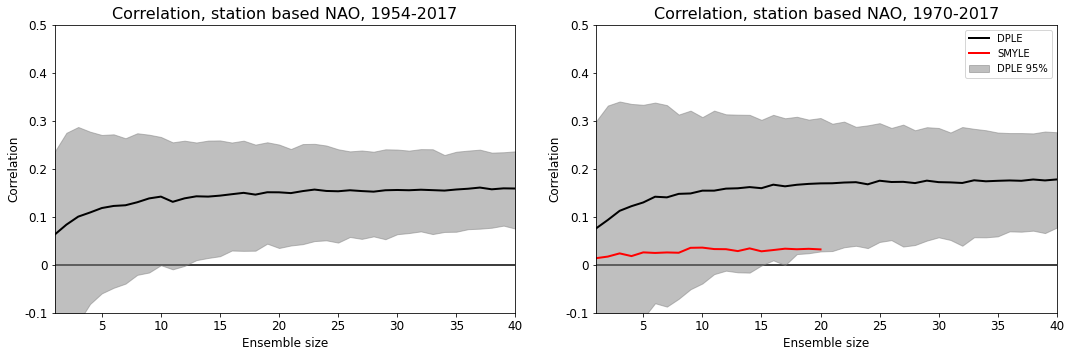

In [166]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_axes([0.05,0.7,0.4,0.25])
ax.set_xlim(1,40)
ax.set_ylim(-0.1,0.5)
ax.set_xticks([5,10,15,20,25,30,35,40])
ax.set_xticklabels(['5','10','15','20','25','30','35','40'], fontsize=12)
ax.set_yticks([-0.1,0,0.1,0.2,0.3,0.4,0.5])
ax.set_yticklabels(['-0.1','0','0.1','0.2','0.3','0.4','0.5'], fontsize=12)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_title('Correlation, station based NAO, 1954-2017', fontsize=16)
ax.plot([1,40],[0,0], color='black', zorder=0)
ax.set_xlabel('Ensemble size', fontsize=12)
ax.set_ylabel('Correlation', fontsize=12)

ax.fill_between(memsize, mincor, maxcor, color='gray', alpha=0.5, label='DPLE 95%')
ax.plot(memsize, meancor, color='black', linewidth=2, label='DPLE')
#ax.plot(memsize, meancor_smylep, color='red', linewidth=2)

ax = fig.add_axes([0.52,0.7,0.4,0.25])
ax.set_xlim(1,40)
ax.set_ylim(-0.1,0.5)
ax.set_xticks([5,10,15,20,25,30,35,40])
ax.set_xticklabels(['5','10','15','20','25','30','35','40'], fontsize=12)
ax.set_yticks([-0.1,0,0.1,0.2,0.3,0.4,0.5])
ax.set_yticklabels(['-0.1','0','0.1','0.2','0.3','0.4','0.5'], fontsize=12)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_title('Correlation, station based NAO, 1970-2017', fontsize=16)
ax.plot([1,40],[0,0], color='black', zorder=0)
ax.set_xlabel('Ensemble size', fontsize=12)
ax.set_ylabel('Correlation', fontsize=12)

ax.fill_between(memsize, mincor_smylep, maxcor_smylep, color='gray', alpha=0.5, label='DPLE 95%')
ax.plot(memsize, meancor_smylep, color='black', linewidth=2, label='DPLE')

ax.plot(memsize[0:20], meancor_smyle[0:20], color='red', linewidth=2, label='SMYLE')
ax.legend()

fig.savefig('cor_vs_members.png', bbox_inches='tight', facecolor='white')

### Skill over the period

In [267]:
print(nao_st_nov_era5)

<xarray.DataArray (init_year: 64)>
array([-1.70789897, -1.91325214,  1.53488959, -0.6885135 , -1.61499301,
       -1.1726048 ,  1.68678348, -0.25880928, -4.11220818, -2.09614323,
       -2.28549139, -1.45419662,  0.70713103, -0.86281374, -3.60527836,
       -0.96591134, -0.93707978, -0.23019646,  1.63668969,  1.16228803,
        1.74113317,  0.02704046, -3.10921805, -1.38248202, -3.17167219,
        0.17265771,  1.43261558, -0.82858474,  2.21697769,  1.87367189,
       -1.38809274, -1.80067295, -0.15626109, -0.57588842,  3.47949056,
        2.26257483,  0.81680747,  1.65574483,  1.68359517,  1.24924176,
        3.28966295, -3.14267276, -1.08697355,  0.17466449,  1.99268689,
        2.38897906, -1.58944055,  0.63615922, -0.27595877, -0.78002997,
        0.69528644, -0.64570578,  1.79912805,  1.85213888, -0.43377592,
       -4.36879022, -1.64485374,  2.67988582,  0.30623803,  2.12737963,
        2.69205323,  1.99871351,  1.11525417,  1.19890095])
Coordinates:
    season     datetime64[ns

In [287]:
nysm=40
rolling_era5 = nao_st_nov_era5.rolling(init_year=nysm, min_periods=nysm, center="True")
rolling_era5 = rolling_era5.construct("yinchunk")
rolling_era5 = rolling_era5.dropna(dim='init_year')

rolling_dple = nao_st_nov_dple.rolling(init_year=nysm, min_periods=nysm, center="True")
rolling_dple = rolling_dple.construct("yinchunk")
rolling_dplem = rolling_dple.mean('M')
rolling_dplem = rolling_dplem.dropna(dim='init_year')

In [288]:
rolling_era5 = rolling_era5.rename({'yinchunk':'time'})
rolling_dplem = rolling_dplem.rename({'yinchunk':'time'})

In [289]:
rolling_correlation = xr.corr(rolling_era5, rolling_dplem, dim='time')
rolling_signif = xs.pearson_r_eff_p_value(rolling_dplem, rolling_era5, dim='time')

In [290]:
from math import nan
rolling_signifplot = rolling_correlation.copy(deep='True')
rolling_signifplot[rolling_signif > 0.1] = nan

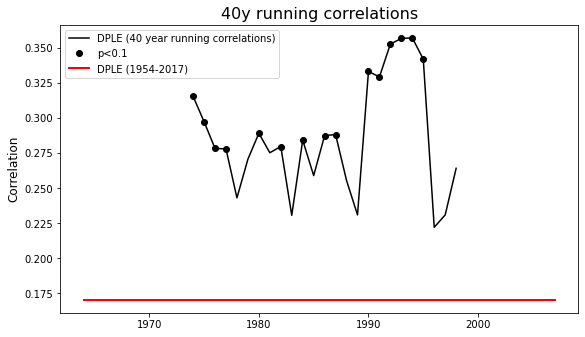

In [291]:
fig = plt.figure(figsize=(16,16))

dplecor = xr.corr(nao_st_nov_dple.mean('M'), nao_st_nov_era5, dim='init_year')

ax = fig.add_axes([0.05,0.7,0.45,0.25])
ax.set_title(str(nysm)+'y running correlations', fontsize=16)
ax.set_ylabel('Correlation', fontsize=12)

ax.plot(rolling_correlation.init_year, rolling_correlation, color='black', label='DPLE ('+str(nysm)+' year running correlations)')
ax.plot(rolling_signifplot.init_year, rolling_signifplot,"o", color='black', label='p<0.1')
ax.plot([1964,2007],[dplecor, dplecor], color='red', linewidth=2, label='DPLE (1954-2017)')
ax.legend()

fig.savefig(str(nysm)+'y_cors.png', bbox_inches='tight', facecolor='white')

In [273]:
print(rolling_correlation)

<xarray.DataArray (init_year: 1)>
array([0.17057969])
Coordinates:
    season     datetime64[ns] 1971-01-15
  * init_year  (init_year) int64 1986


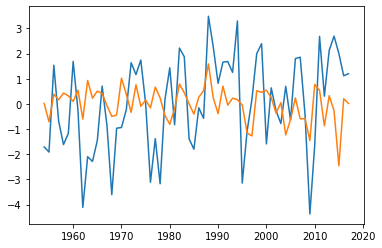

In [256]:
plt.plot(nao_st_nov_era5.init_year, nao_st_nov_era5)
plt.plot(nao_st_nov_dple.init_year, nao_st_nov_dple.mean('M'))

In [253]:
print(nao_st_nov_era5.init_year)

<xarray.DataArray 'init_year' (init_year: 64)>
array([1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017])
Coordinates:
    season     datetime64[ns] 1971-01-15
  * init_year  (init_year) int64 1954 1955 1956 1957 ... 2014 2015 2016 2017
